In [1]:
# load required packages
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
import geopy.distance
import random
from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)
# import the graph
filepath = 'champaign_processed.graphml'
G = ox.load_graphml(filepath)
for i in G.nodes:
    Neighbour = list(G.neighbors(i))
    for item in Neighbour:
        route = nx.shortest_path_length(G,i,item,weight = 'length')
        if route <=10 and G.nodes[i]['pop_score_block'] != -1:
            G.nodes[item]['pop_score_block'] = -1
 #change data types of some attributes
DePop = []
for i in G.nodes:
    if G.nodes[i]['pop_score_block'] == -1:
        G.nodes[i]['pop_score_block'] = 0
        DePop.append(i)
for _,data in G.nodes(data=True):
    data['pop_score_tract'] = float(data['pop_score_tract'])
    data['pop_score_block'] = float(data['pop_score_block'])    
    

In [2]:
nx.is_strongly_connected(G) 

True

In [3]:
# create a dictionary for all possible routs
node_ID = list(G.nodes())
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='distance')) 

In [38]:
# or start with some random input
facility1 = []
facility2 = []
for k in range(5):
    facility1.append(random.choice(node_ID))
    facility2.append(random.choice(node_ID))
FACIL = [facility1,facility2]
print(FACIL)

[[6088807084, 5812443303, 6879844901, 38082698, 37996510], [6072125907, 6086723112, 37978366, 37997162, 5830533242]]


In [39]:
SCORE_O = []
for it in FACIL:
    facility = it
    score_old = 0
    for i in node_ID:
        path = min([path_lengths[j][i] for j in facility])
        score_old = score_old+path*G.nodes[i]['pop_score_block']
    SCORE_O.append(score_old)
SCORE_O

[11434.978304742664, 11523.584762865783]

In [40]:
count = 0
SCORE_N = [x-1 for x in SCORE_O]
while abs(SCORE_N[0]-SCORE_N[1])>20 and count<3000:
    count+=1
    for facility in FACIL:
        index = FACIL.index(facility)
        score_new = SCORE_N[index]
        score_old = SCORE_O[index]
        while score_new < score_old:
            score_old = score_new
            for i in range(5):
                score_new = 0 
                neigh = list(G.neighbors(facility[i]))
                neigh.append(facility[i])
                temp = facility
                TEMP_SCORE = []
                for item in neigh:
                    temp_score = 0
                    temp[i] = item
                    for j in node_ID:
                        path = min([path_lengths[t][j] for t in temp])
                        temp_score = temp_score+path*G.nodes[j]['pop_score_block']
                    TEMP_SCORE.append(temp_score)
                score_new = min(TEMP_SCORE)
                step_dir = neigh[TEMP_SCORE.index(score_new)]
                facility[i] = step_dir
        worse = max(SCORE_N)
        worse_id = SCORE_N.index(worse)
        SCORE_N[index] = score_new
        SCORE_O[index] = score_old
        FACIL[index] = facility
    t0 = FACIL[0]
    t1 = FACIL[1]
    newfacil = []
    for i in range(5):
        x = (G.nodes[t0[i]]['x']+G.nodes[t1[i]]['x'])/2
        y = (G.nodes[t0[i]]['y']+G.nodes[t1[i]]['y'])/2
        newfacil.append(ox.get_nearest_node(G,(y,x)))
    FACIL[worse_id] = newfacil
print(count)
print(FACIL)

3000
[[1520427765, 38007924, 38119865, 38084393, 38058600], [1520427765, 38008142, 7115837105, 38084393, 5421688927]]


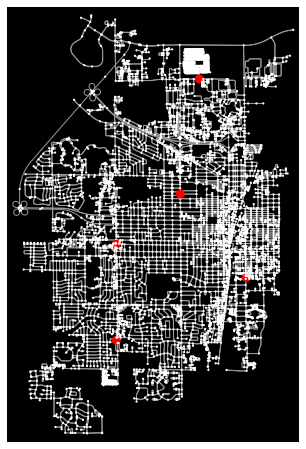

In [42]:
nc = ['r' if node in FACIL[1]  else 'w' for node in G.nodes()]
ns = [80 if node in FACIL[1]  else 5 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

In [43]:
SCORE_N

[7093.228304742719, 7149.3895055499725]